In [14]:
import jax
import jax.numpy as jnp
import numpy as np
from tensorflow_probability.substrates import jax as tfp
import matplotlib.pyplot as plt
import seaborn as sns

import pathfinder
import pathfinder.util

tfd = tfp.distributions

Pathfinder can be used with any probabilistic programming framework that provides JAX log probability functions. 

Here's an example with tensforflow probability:
#### Data:

In [3]:
num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32
)  # treatment effects
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32
)  # treatment SE

#### Model:

In [4]:
model = tfd.JointDistributionSequential(
    [
        tfd.Normal(loc=0.0, scale=10.0, name="avg_effect"),  # `mu` above
        tfd.Normal(loc=5.0, scale=1.0, name="avg_stddev"),  # `log(tau)` above
        tfd.Independent(
            tfd.Normal(
                loc=jnp.zeros(num_schools),
                scale=jnp.ones(num_schools),
                name="school_effects_standard",
            ),  # `theta_prime`
            reinterpreted_batch_ndims=1,
        ),
        lambda school_effects_standard, avg_stddev, avg_effect: (
            tfd.Independent(
                tfd.Normal(
                    loc=(
                        avg_effect[..., jnp.newaxis]
                        + jnp.exp(avg_stddev[..., jnp.newaxis])
                        * school_effects_standard
                    ),  # `theta` above
                    scale=treatment_stddevs,
                ),
                name="treatment_effects",  # `y` above
                reinterpreted_batch_ndims=1,
            )
        ),
    ]
)


def target_logprob_fn(avg_effect, avg_stddev, school_effects_standard):
    """Unnormalized target density as a function of states."""
    return model.log_prob(
        (avg_effect, avg_stddev, school_effects_standard, treatment_effects)
    )


transf = pathfinder.util.StackedTensorTransformer(model.event_shape[:-1])
unstack_fn = transf.unstack_pure_fn()

def logp(x):
    return target_logprob_fn(*unstack_fn(x))

#### Pathfinder variational inference:
here we use pathfinder to draw 5000 approximate samples from the posterior distribution of the model:

In [ ]:
rng_key = jax.random.PRNGKey(10)
sample = jnp.array(transf.stack(model.sample(1,seed=rng_key)))[0]

maxiter = 100
maxcor = 10
M = 5000

elbo, x, phi = pathfinder.pathfinder(rng_key, logp, sample, maxiter, maxcor, M)

#### Visualization

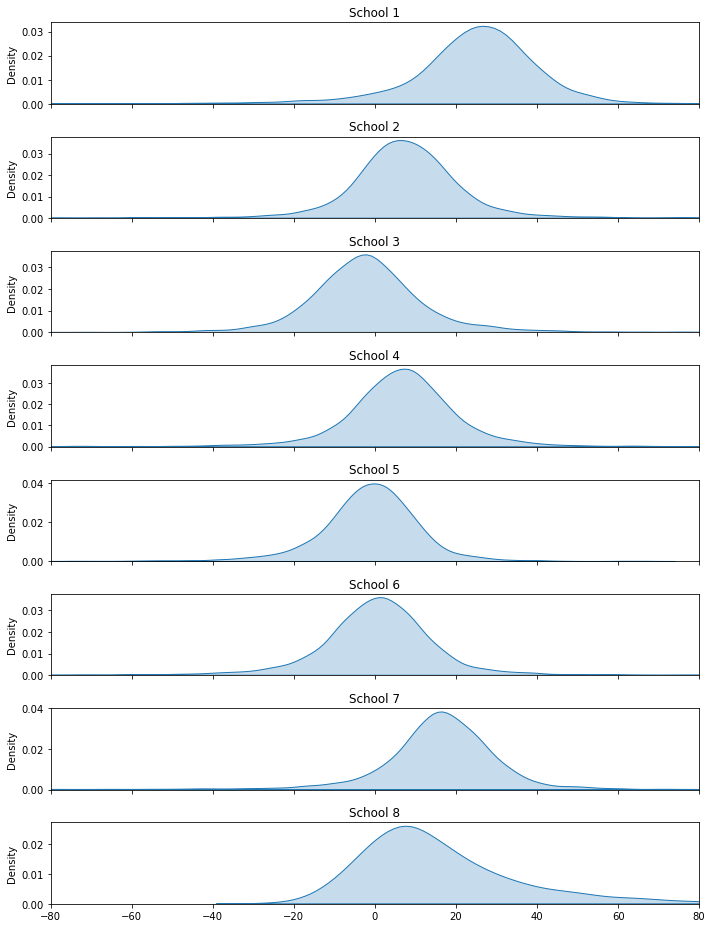

In [34]:
sample_dict = dict(zip(["avg effect", "avg std", "school std"], 
                       unstack_fn(phi)))

school_effect = sample_dict["avg effect"][:,None]+\
                np.exp(sample_dict["avg std"][:,None])*sample_dict["school std"]

fig, axs = plt.subplots(num_schools,1, figsize=(10,13), sharex=True)
for i,ax in zip(range(num_schools),axs):
    sns.kdeplot(school_effect[:, i], ax=ax, shade=True)
    ax.set_title(f"School {i+1}")
ax.set_xlim(-80,80)
fig.tight_layout()